In [1]:
# Python 3.8
# Copyright Alban GOUGOUA

# Exercice d'évaluation pour le poste Inria / AP-HP

## Prérequis
Ce bout de code ci-dessous a été fourni par les évaluateurs. Il permet de lire les données présentes dans le fichier **data.db**.

In [2]:
import pandas as pd
from sqlalchemy import create_engine

engine = create_engine('sqlite:///data.db', echo=False)
con = engine.connect()
df_patient = pd.read_sql('select * from patient', con=con)
df_pcr = pd.read_sql('select * from test', con=con)
con.close()

## Question 1
*Mettre en évidence les problèmes de qualité de données (données incohérentes, données manquantes etc.)*

### Importer les différentes librairies nécessaires au travail

In [3]:
# Data analysis
import numpy as np
import re
import datetime

# Visualization
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

### Description des données : df_patient

*Quelles sont les variables disponibles ?*

In [4]:
print(df_patient.columns.values)

['patient_id' 'given_name' 'surname' 'street_number' 'address_1' 'suburb'
 'postcode' 'state' 'date_of_birth' 'age' 'phone_number' 'address_2']


*Lesquelles des variables sont catégorielles ou quantitatives ?*
* Nominale : given_name, surname, address_1, suburb, postcode, state, phone_number, address_2

*Lesquelles des variables sont numériques ?*
* Discrète : street_number, age
* Continue : date_of_birth

In [5]:
# Preview data
df_patient.head()

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
0,221958,matisse,clarke,13.0,rene street,ellenbrook,2527,wa,19710708.0,32.0,08 86018809,westella
1,771155,joshua,elrick,23.0,andrea place,east preston,2074,nsw,19120921.0,34.0,02 97793152,foxdown
2,231932,alice,conboy,35.0,mountain circuit,prospect,2305,nsw,19810905.0,22.0,02 20403934,None
3,465838,sienna,craswell,39.0,cumberlegeicrescent,henty,3620,wa,19840809.0,30.0,02 62832318,jodane
4,359178,joshua,bastiaans,144.0,lowrie street,campbell town,4051,nsw,19340430.0,31.0,03 69359594,None


In [6]:
df_patient.tail()

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
19995,368617,abby,None,19.0,john cleland crescent,boyne island,2290,nsw,19570210.0,NaN,02 92489054,glenmore
19996,796658,dale,priest,19.0,bellchambers crescent,hoppers crossing,3033,wa,19590619.0,31.0,07 20549476,None
19997,511885,alessia,mawlai,4.0,miller street,smithfield,3616,tas,NaN,26.0,03 83466737,None
19998,985932,hannah,mason,1.0,halligan place,beaumaris,2443,wa,19140304.0,25.0,04 41125514,None
19999,925217,jack,mcveigh,5.0,alinda place,thornlands,4350,nsw,19230521.0,26.0,07 52535106,None


*Lesquelles des variables comporteraient des erreurs ou des valeurs manquantes ?*

Il est assez difficile de parcourir l'ensemble des données **df_patient** et relever toutes les erreurs.
Du bref aperçu, je note plus qu'il y a des données manquantes dans la plupart des variables :
* **Moins de 5%** : postcode, suburb, street_number, surname, given_name, address_1, phone_number (*variables donc nécessaires pour la détection des doublons*) ; de plus, il n'y a aucune ligne avec des valeurs manquantes dans toutes ces variables en même temps
* **Entre 5-20%** : state, date_of_birth, age
* **Plus de 50%** : address_2 (*cette variable sera donc supprimée de notre dataframe*)

In [7]:
# df_patient['patient_id'] == len(df_patient)
# df_patient['patient_id'] is the reference

round((df_patient.isna().sum() / df_patient.patient_id.count()).sort_values() * 100, 2)

patient_id        0.00
postcode          1.00
suburb            1.06
street_number     1.91
surname           2.12
given_name        2.20
address_1         3.98
phone_number      4.60
state             9.95
date_of_birth    10.06
age              19.98
address_2        60.54
dtype: float64

In [8]:
# all features which are less 5% of NaN values
# checking of NaN values with multiple conditions
df_patient[(df_patient.given_name.isna()) & (df_patient.surname.isna()) & (df_patient.street_number.isna()) & \
          (df_patient.address_1.isna()) & (df_patient.suburb.isna()) & (df_patient.postcode.isna()) & \
           (df_patient.phone_number.isna())]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2


*Quels sont les types des différentes variables ?*
* 3 variables sont des flottants (float)
* 8 variables des chaînes de caractère (string)

In [9]:
df_patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   patient_id     20000 non-null  int64  
 1   given_name     19560 non-null  object 
 2   surname        19575 non-null  object 
 3   street_number  19618 non-null  float64
 4   address_1      19204 non-null  object 
 5   suburb         19788 non-null  object 
 6   postcode       19801 non-null  object 
 7   state          18010 non-null  object 
 8   date_of_birth  17989 non-null  float64
 9   age            16003 non-null  float64
 10  phone_number   19081 non-null  object 
 11  address_2      7893 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 1.8+ MB


#### Analyse des variables quantitatives

In [10]:
df_patient.describe(include=['O'])

,given_name,surname,address_1,suburb,postcode,state,phone_number,address_2
count,19560,19575,19204,19788,19801,18010,19081,7893
unique,1171,4273,4326,2925,2021,102,17916,3460
top,emiily,white,paul coe crescent,toowoomba,4350,nsw,08 62513595,brentwood vlge
freq,373,539,57,167,96,6143,4,85


Source pour l'écriture d'une adresse en Australie : https://www.parcelmonkey.com/how-to-guides/how-to-address-mail-to-australia
* street_number address_1
* suburb state postcode

La variable **address_2** avec son grand nombre de valeurs manquantes (**60.54%**) n'est pas nécessaire à notre étude. Elle sera supprimée de notre jeu de données.

*Suppression de la variable **address_2** de notre dataframe.*

In [11]:
df_patient = df_patient.drop(columns='address_2')

**Cohérence des variables quantitatives :**

Pour vérifier la cohérence des valeurs de chaque variable quantitative, j'écrirai 2 fonctions de recherche de valeurs :
* l'une alphabétique appelée *search_alphabetic_values* ;
* l'autre numérique appelée *search_numeric_values*.

Ces fonctions utiliseront les expressions regulières (module *re*).

In [12]:
def search_alphabetic_values(value):
    """
    This function allows the identification of alphabetic values.
        It returns a string or a NoneType according to the length of the result of re.findall.
    
    @parameters
        value: string
    @return
        result: string or NoneType
    """
    result = re.findall(r'\b\D+\B', value)
    if len(result) != 0:
        return result[0]

In [13]:
def search_numeric_values(value):
    """
    This function allows the identification of numeric values.
        It returns a string or a NoneType according to the length of the result of re.findall.
    
    @parameters
        value: string
    @return
        result: string or NoneType
    """
    result = re.findall(r'\b\d+', value)
    if len(result) != 0:
        return result[0]

In [14]:
# Fill NaN by simple values
df_patient.given_name = df_patient.given_name.fillna("")
df_patient.surname = df_patient.surname.fillna("")
df_patient.address_1 = df_patient.address_1.fillna("")
df_patient.suburb = df_patient.suburb.fillna("")
df_patient.postcode = df_patient.postcode.fillna('0')
df_patient.state = df_patient.state.fillna("")
df_patient.phone_number = df_patient.phone_number.fillna('0')

In [15]:
# Select all object type's columns
columns = list(df_patient.select_dtypes(include=['object']).columns.values)

* Les variables **given_name**, **surname** et **state** semblent cohérentes car ne comportent aucune valeur numérique.
* La variable **address_1** comportent 2 valeurs numériques qui sont en réalité des valeurs alphanumériques désignant le domicile exact de la personne.
* Les variables **suburb** et **postcode** comptent chacun 14 valeurs incohérentes :
    * en affichant toutes les valeurs Incohérentes de l'un ou l'autre des variables, je m'aperçois que la taille du dataframe est le même avec les mêmes valeurs d'indexes.
    * par conséquent,il y a des erreurs de saisie pour ces lignes en inversant les variables : **postcode** dans **suburb** et vis-versa. Il faudra donc les remettre dans l'ordre avant tout.
* La variable **phone_number** quant à elle est totalement cohérente car ne comporte aucune valeur alphabétique.

In [16]:
# Figure number of alphabetic or numeric values out 
number_checking = {}
for column in columns:
    if column in ['postcode', 'phone_number']:
        number_checking[column] = df_patient[column].count() - df_patient[column].apply(search_alphabetic_values).\
                                                                                                    isna().sum()
    else:
        number_checking[column] = df_patient[column].count() - df_patient[column].apply(search_numeric_values).\
                                                                                                    isna().sum()

# View results by a DataFrame
df_checking = pd.DataFrame.from_dict(number_checking, orient='index', columns=['coherence_checking'])
df_checking.loc[:]

,coherence_checking
given_name,0
surname,0
address_1,2
suburb,14
postcode,14
state,0
phone_number,0


In [17]:
# Numeric values in feature address_1
df_patient[df_patient.address_1.apply(search_numeric_values).isna() == False]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number
1322,313942,joe,reimef,68.0,home 186,windsor,7019,nsw,19581213.0,26.0,04 22861452
3763,186516,hannah,clarke,6.0,villa 3,brighton-le-sands,3996,qln,19730115.0,NaN,07 53595738


In [18]:
# Numeric values in feature suburb or alphabetic values in feature postcode
df_patient[(df_patient.suburb.apply(search_numeric_values).isna() == False) | \
           (df_patient.postcode.apply(search_alphabetic_values).isna() == False)]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number
3976,810644,juliana,grosvenor,5.0,connelly pace,3023,port noarlunga south,tas,19991215.0,NaN,03 55227740
4080,986559,kirra,choi-lundberg,102.0,centaurus street,6168,naremburn,vic,19261104.0,27.0,08 69584599
5792,752873,lochlan,blake,258.0,,4216,toowoobma,wa,19080821.0,31.0,02 84630666
6218,902348,isaac,nakoje,19.0,collier street,6017,brighton,,19640421.0,8.0,02 69439226
6618,678110,jaden,green,5.0,dovey place,3185,oraneg,vic,19151204.0,23.0,02 73534391
9653,690348,andrew,ryan,20.0,mainwaring rich circuit,3020,blacktown,wa,19760001.0,22.0,0
9718,727290,tiffany,loukes,31.0,leal place,467l0,forest hill,nsw,19760706.0,23.0,0
11333,738103,hugi,pascoe,167.0,leita court,3023,port lincoln,nsw,19040401.0,NaN,07 84786511
14255,684359,sonia,green,50.0,kalgoorlie crescent,6112,ashfield,sa,NaN,9.0,03 46671647
15479,355033,abby,yoob,243.0,weston street,3181,forest hill,,19660615.0,26.0,02 68667816


L'Australie compte 6 États et 2 Territoires selon le site officiel du tourisme australien (https://www.australia.com/en/facts-and-planning/about-australia/cities-states-and-territories.html).
Ces États et Territoires (dans notre dataframe représentés par la variable **state**) sont :
* Australian Capital Territory (**act**) ;
* New South Wales (**nsw**) ;
* Northern Territory (**nt**) ;
* Queensland (**qld**) ;
* South Australia (**sa**) ;
* Tasmania (**tas**) ;
* Victoria (**vic**) ;
* et Western Australia (**wa**).

Mais notre variable **state** compte 103 valeurs différentes (en ajoutant la valeur **""** chaîne vide qui a servi à remplir les valeurs manquantes) : cela indique qu'il y a plusieurs erreurs de saisie (*139 au total*). Notre variable sera donc sujet à correction.

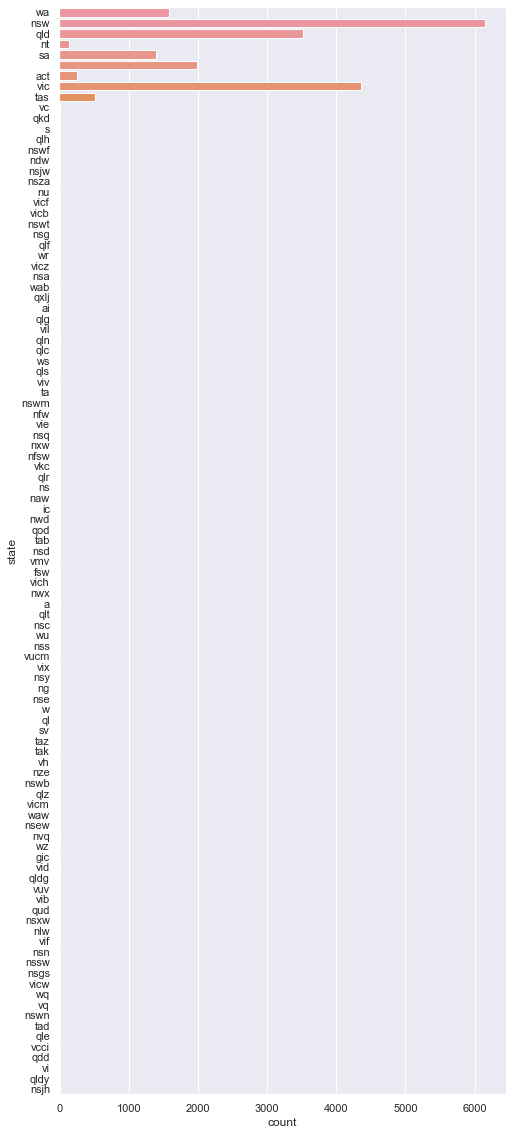

In [19]:
fig, ax = plt.subplots(figsize=(8, 20))
sns.countplot(y=df_patient.state, ax=ax)

In [20]:
df_patient.state.describe()

count     20000
unique      103
top         nsw
freq       6143
Name: state, dtype: object

In [21]:
# Value counts which are errors
(~df_patient.state.isin(['act', 'nsw', 'nt', 'qld', 'sa', 'tas', 'vic', 'wa', ""])).sum()

139

Vérification des codes postaux (variable **postcode**). Nous comptons 14 intervalles de codes postaux correspondants aux différents États et Territoires selon le site de la poste australienne (https://postcode.auspost.com.au/free_display.html?id=1) :
* 0200-0299 : act
* 0800-0999 : nt
* 1000-2599 : nsw
* 2600-2619 : act
* 2620-2899 : nsw
* 2900-2920 : act
* 2921-2999 : nsw
* 3000-3999 : vic
* 4000-4999 : qld
* 5000-5999 : sa
* 6000-6999 : wa
* 7000-7999 : tas
* 8000-8999 : vic
* 9000-9999 : qld

Cette relation entre les variables **postcode** et **state** me permettra de faire l'imputation des valeurs manquantes et la correction des erreurs de saisie de la variable **state**.

*Traitement de la variable **postcode** :*
* remplacer les valeurs manquantes par '0' (nous avons seulement **1%** de valeurs manquantes) ;
    * **tâche réalisée plus haut.**
* calculer la proportion de valeurs alphabétiques présentes ;
    * **tâche réalisée plus haut.**
* corriger les valeurs alphabétiques présentes par les valeurs correspondantes de la variable **suburb** ;
* changer le type de cette variable par le type numpy.int64 ;
* supprimer toutes les lignes qui ont pour valeur '0' ; la variable **postcode** a le plus faible pourcentage de valeurs manquantes et il est de **1%** ;
* vérifier que les valeurs numériques correspondent à celles données par la poste australienne.

In [22]:
# Indexes of alphabetic values in feature postcode
index_changing = list(df_patient[(df_patient.suburb.apply(search_numeric_values).isna() == False) | \
           (df_patient.postcode.apply(search_alphabetic_values).isna() == False)].index)

print(index_changing)

[3976, 4080, 5792, 6218, 6618, 9653, 9718, 11333, 14255, 15479, 15575, 18658, 18784, 19150]


In [23]:
# Change alphabetic values by numeric values of feature suburb
transition = ""
for index in index_changing:
    transition = df_patient.postcode.iloc[index]
    df_patient.postcode.iloc[index] = df_patient.suburb.iloc[index]
    df_patient.suburb.iloc[index] = transition

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [24]:
# Change checking
df_patient[(df_patient.suburb.apply(search_numeric_values).isna() == False) | \
           (df_patient.postcode.apply(search_alphabetic_values).isna() == False)]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number


La correction des valeurs a fonctionné et m'a permis de voir qu'une des valeurs de **postcode** à l'index 9718 est alphanumérique (valeur incohérente) 467l0. Je vais le corriger par la valeur 4670 (je supprime le *l*).

In [25]:
for index in index_changing:
    print(df_patient.postcode.iloc[index], " at the index ", index)

3023  at the index  3976
6168  at the index  4080
4216  at the index  5792
6017  at the index  6218
3185  at the index  6618
3020  at the index  9653
467l0  at the index  9718
3023  at the index  11333
6112  at the index  14255
3181  at the index  15479
3764  at the index  15575
4214  at the index  18658
4160  at the index  18784
3133  at the index  19150


In [26]:
# Correct alphanumeric value by deleting the character l
df_patient.postcode.iloc[9718] = '4670'

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [27]:
# Change the type of feature postcode
df_patient.postcode = df_patient.postcode.astype(np.int64)

In [28]:
# Delete '0' values's rows
df_patient = df_patient[df_patient.postcode != 0]

In [29]:
# Check deleting
df_patient.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19801 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   patient_id     19801 non-null  int64  
 1   given_name     19801 non-null  object 
 2   surname        19801 non-null  object 
 3   street_number  19422 non-null  float64
 4   address_1      19801 non-null  object 
 5   suburb         19801 non-null  object 
 6   postcode       19801 non-null  int64  
 7   state          19801 non-null  object 
 8   date_of_birth  17819 non-null  float64
 9   age            15842 non-null  float64
 10  phone_number   19801 non-null  object 
dtypes: float64(3), int64(2), object(6)
memory usage: 1.8+ MB


**Aucune valeur** de la variable **postcode** n'est en dehors des informations de la poste australienne. Elles sont comprises entre **0200-9999**.

In [30]:
df_patient[df_patient.postcode < 200].postcode.count()

0

In [31]:
df_patient[df_patient.postcode > 9999].postcode.count()

0

*Traitement de la variable **suburb** :*
* calculer la proportion des valeurs numériques présentes ;
    * **tâche réalisée plus haut.**
* corriger les valeurs numériques présentes par les valeurs alphabétiques de la variable **postcode** ;
    * **tâche réalisée plus haut.**
* corriger toutes les caractères vides "" (**1.06%**) par la valeur la plus fréquente alphabétique ;

In [32]:
# Before correction
df_patient.suburb.value_counts()

                  211
toowoomba         167
frankston         108
brighton           93
port macquarie     92
                 ... 
ellesmere           1
muntham             1
mulolewa            1
loch                1
sherbrooke          1
Name: suburb, Length: 2901, dtype: int64

In [33]:
# Correction
df_patient.suburb = df_patient.suburb.replace("", df_patient.suburb.value_counts().index[1])

In [34]:
# After correction
df_patient.suburb.value_counts()

toowoomba           378
frankston           108
brighton             93
port macquarie       92
blacktown            92
                   ... 
ross                  1
rosslyn lpark         1
meringa               1
central wattagan      1
wilmot                1
Name: suburb, Length: 2900, dtype: int64

In [35]:
# NaN value counts
df_patient.suburb.isna().sum()

0

*Traitement des variables **given_name** et **surname** :*
* créer une variable **name** qui est la concaténation des deux variables ;
* vérifier qu'il n'y a aucune valeur manquante dans la nouvelle variable **name** ;
* supprimer les variables **given_name** et **surname**.

In [36]:
# Create the feature name
df_patient['name'] = df_patient.given_name + " " + df_patient.surname

In [37]:
# Checking of NaN values in feature name
df_patient.name.isna().sum()

0

Il se trouve dans notre jeu de données *4 lignes* où le prénom et le nom n'ont pas été renseignés.

In [38]:
df_patient[df_patient.name == " "]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,name
4598,340891,,,70.0,fawkner street,gorokan,3178,vic,19150429.0,24.0,07 49934506,
6663,211362,,,3.0,sternberg crescent,elsterneick,2502,nsw,19000422.0,32.0,03 96314344,
10664,644475,,,22.0,john xxiii college,craigmore,5046,tas,19781105.0,31.0,0,
18526,207001,,,20.0,kirkwood crescent,cooroy,3231,,19960825.0,30.0,03 16641630,


In [39]:
# Preview data
df_patient.head()

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,name
0,221958,matisse,clarke,13.0,rene street,ellenbrook,2527,wa,19710708.0,32.0,08 86018809,matisse clarke
1,771155,joshua,elrick,23.0,andrea place,east preston,2074,nsw,19120921.0,34.0,02 97793152,joshua elrick
2,231932,alice,conboy,35.0,mountain circuit,prospect,2305,nsw,19810905.0,22.0,02 20403934,alice conboy
3,465838,sienna,craswell,39.0,cumberlegeicrescent,henty,3620,wa,19840809.0,30.0,02 62832318,sienna craswell
4,359178,joshua,bastiaans,144.0,lowrie street,campbell town,4051,nsw,19340430.0,31.0,03 69359594,joshua bastiaans


In [40]:
# Drop features given_name and surname
df_patient = df_patient.drop(columns=['given_name', 'surname'])

In [41]:
# Rearrange columns
df_patient = df_patient[['patient_id', 'name', 'street_number', 'address_1', 'suburb', 'state', 'postcode', \
                        'date_of_birth', 'age', 'phone_number']]

# Preview data
df_patient.head()

,patient_id,name,street_number,address_1,suburb,state,postcode,date_of_birth,age,phone_number
0,221958,matisse clarke,13.0,rene street,ellenbrook,wa,2527,19710708.0,32.0,08 86018809
1,771155,joshua elrick,23.0,andrea place,east preston,nsw,2074,19120921.0,34.0,02 97793152
2,231932,alice conboy,35.0,mountain circuit,prospect,nsw,2305,19810905.0,22.0,02 20403934
3,465838,sienna craswell,39.0,cumberlegeicrescent,henty,wa,3620,19840809.0,30.0,02 62832318
4,359178,joshua bastiaans,144.0,lowrie street,campbell town,nsw,4051,19340430.0,31.0,03 69359594


*Traitement de la variable **address_1** :*
* corriger toutes les valeurs manquantes (**3.98%**) par la valeur "" ;
    * **tâche réalisée plus haut.**

In [42]:
# After correction
df_patient.address_1.value_counts()

                     790
paul coe crescent     56
burkitt street        55
wilkins street        54
totterdell street     49
                    ... 
glenorcht street       1
clubbe crwscent        1
quinn street           1
hodges street          1
meerup street          1
Name: address_1, Length: 4317, dtype: int64

In [43]:
# NaN value counts
df_patient.address_1.isna().sum()

0

*Traitement de la variable **phone_number** :*
* corriger toutes les valeurs manquantes (**4.60%**) par la valeur '0' ;
    * **tâche réalisée plus haut.**

Afin de m'assurer de la qualité de cette variable, je consulte le site officiel des médias et communications d'Australie (https://www.acma.gov.au/choose-your-phone-number#types-of-phone-numbers). La longueur d'un numéro de téléphone est de 10 ; par exemple '0102030405'.

Dans notre jeu de données, il est de 11 car il est de la forme '01 02030405'.

*NB : Les 919 valeurs de longueur 1 sont celles corrigées par la valeur '0' plus haut.*

In [44]:
# Unique values of the length of each value
df_patient.phone_number.apply(len).value_counts()

11    18890
1       911
Name: phone_number, dtype: int64

In [45]:
# After correction
df_patient.phone_number.value_counts()

0              911
07 85673315      4
04 27462876      4
07 50066933      4
04 75216233      4
              ... 
03 63698661      1
07 29853834      1
08 92762134      1
02 64492750      1
07 29757496      1
Name: phone_number, Length: 17733, dtype: int64

In [46]:
# NaN value counts
df_patient.phone_number.isna().sum()

0

*La variable **phone_number** pourrait être une variable explicative et très utile pour la fonction de détection de doublons*.

In [47]:
df_patient[df_patient.phone_number == '03 10035431']

,patient_id,name,street_number,address_1,suburb,state,postcode,date_of_birth,age,phone_number
3364,622220,thomas webb,58.0,giles street,willtton,ai,2756,19670825.0,39.0,03 10035431
7161,671302,thomas webb,58.0,giles street,willetton,sa,2756,19670825.0,39.0,03 10035431
18998,397486,thomas webb,59.0,giles steeet,willetton,sa,2756,19670825.0,39.0,03 10035431
19684,499158,thomas webb,58.0,giles street,willtdeton,sa,2756,19679825.0,39.0,03 10035431


In [48]:
df_patient[df_patient.phone_number == '07 26649590']

,patient_id,name,street_number,address_1,suburb,state,postcode,date_of_birth,age,phone_number
4395,695600,richard hermans,2.0,goodparla street,valentine,tas,3371,19462115.0,22.0,07 26649590
8877,894878,richard hermans,13.0,goodparla street,valentine,tas,3371,NaN,22.0,07 26649590
11293,464534,richard hermans,12.0,goodparla street,valentine,tas,3371,19461125.0,22.0,07 26649590
11840,757846,ritchad hermans,12.0,goodparla street,valentine,,3371,19461125.0,22.0,07 26649590


*Traitement de la variable **state** :*
* corriger toutes les valeurs manquantes (**9.95%**) par la valeur "" ;
    * **tâche réalisée plus haut.**
* utiliser la variable **postcode** pour corriger toutes les erreurs de la variable **state** :
    * j'utilise la règle d'affectation du code postal donnée par la poste australienne :
        * 0200-0299 : act
        * 0800-0999 : nt
        * 1000-2599 : nsw
        * 2600-2619 : act
        * 2620-2899 : nsw
        * 2900-2920 : act
        * 2921-2999 : nsw
        * 3000-3999 : vic
        * 4000-4999 : qld
        * 5000-5999 : sa
        * 6000-6999 : wa
        * 7000-7999 : tas
        * 8000-8999 : vic
        * 9000-9999 : qld

In [49]:
# Correction of feature state
    # 0200-0299
df_patient.loc[(df_patient.postcode >= 200) & (df_patient.postcode < 300), 'state'] = 'act'
    # 0800-0999
df_patient.loc[(df_patient.postcode >= 800) & (df_patient.postcode < 1000), 'state'] = 'nt'
    # 1000-2599
df_patient.loc[(df_patient.postcode >= 1000) & (df_patient.postcode < 2600), 'state'] = 'nsw'
    # 2600-2619
df_patient.loc[(df_patient.postcode >= 2600) & (df_patient.postcode < 2620), 'state'] = 'act'
    # 2620-2899
df_patient.loc[(df_patient.postcode >= 2620) & (df_patient.postcode < 2900), 'state'] = 'nsw'
    # 2900-2920
df_patient.loc[(df_patient.postcode >= 2900) & (df_patient.postcode < 2921), 'state'] = 'act'
    # 2921-2999
df_patient.loc[(df_patient.postcode >= 2921) & (df_patient.postcode < 3000), 'state'] = 'nsw'
    # 3000-3999
df_patient.loc[(df_patient.postcode >= 3000) & (df_patient.postcode < 4000), 'state'] = 'vic'
    # 4000-4999
df_patient.loc[(df_patient.postcode >= 4000) & (df_patient.postcode < 5000), 'state'] = 'qld'
    # 5000-5999
df_patient.loc[(df_patient.postcode >= 5000) & (df_patient.postcode < 6000), 'state'] = 'sa'
    # 6000-6999
df_patient.loc[(df_patient.postcode >= 6000) & (df_patient.postcode < 7000), 'state'] = 'wa'
    # 7000-7999
df_patient.loc[(df_patient.postcode >= 7000) & (df_patient.postcode < 8000), 'state'] = 'tas'
    # 8000-8999
df_patient.loc[(df_patient.postcode >= 8000) & (df_patient.postcode < 9000), 'state'] = 'vic'
    # 9000-9999
df_patient.loc[(df_patient.postcode >= 9000) & (df_patient.postcode < 10000), 'state'] = 'qld'

In [50]:
# After correction
df_patient.state.value_counts()

nsw    6652
vic    4886
qld    3786
wa     1841
sa     1560
tas     527
act     372
nt      177
Name: state, dtype: int64

In [51]:
df_patient.state.isna().sum()

0

Après le traitement des variables qualitatives, je fais l'analyse suivante :
* Il y a 17067 valeurs uniques pour la variable **name** sur 19081 valeurs dans notre jeu de données ; cette variable servira clairement à la détection de doublons.
* De 102 valeurs, nous nous retrouvons à 8 valeurs uniques pour la variable **state**.
* De même que la variable **name**, la variable **phone_number** compte un grand nombre  de valeurs uniques que le nombre de valeurs total dans le jeu de données ; cette variable est donc également nécessaire pour la détection de doublons.

Un aperçu des lignes dupliquées dans les variables **name** et **phone_number** révèle qu'il y a 770 lignes concernées.

In [52]:
# After correction of all qualitative features
df_patient.describe(include=['O'])

,name,address_1,suburb,state,phone_number
count,19801,19801,19801,19801,19801
unique,17067,4317,2900,8,17733
top,white,,toowoomba,nsw,0
freq,13,790,378,6652,911


In [53]:
# Preview of duplicated rows in features name and phone_number
df_patient[(df_patient.name.duplicated()) & (df_patient.phone_number.duplicated())]

,patient_id,name,street_number,address_1,suburb,state,postcode,date_of_birth,age,phone_number
488,749150,benjamin weidenhoffer,436.0,kadina crescent,joyner,tas,7310,19541224.0,39.0,03 02607538
568,303861,dylan,5.0,blake place,campsie,nsw,2306,19010730.0,NaN,0
575,675581,joshua reid,18.0,clare dennis avenue,edgecliff,vic,3585,19760803.0,NaN,0
605,291232,alicia clarke,39.0,badenoch crescent,gidgegannup,qld,4066,19700619.0,28.0,07 16836996
1085,915131,georgia hope,176.0,constitution avenue,brunswick heads,vic,3025,19381108.0,29.0,04 70023929
...,...,...,...,...,...,...,...,...,...,...
19896,535564,marcus reinbach,2.0,wangara street,hazelbrook,vic,3931,19670124.0,30.0,08 38366451
19900,916708,edward baillie,8.0,majura avdnue,bayview,qld,4118,19671201.0,NaN,04 21767460
19924,916386,corie webb,91.0,collings street,berwick,qld,4506,19880101.0,22.0,07 83704242
19949,434796,xepheren beatton,4.0,the canberea tospital,albury,nsw,2089,19910237.0,32.0,07 23534602


#### Analyse des variables numériques

In [54]:
df_patient.describe()

,patient_id,street_number,postcode,date_of_birth,age
count,19801.000000,19422.000000,19801.000000,1.781900e+04,15842.000000
mean,553955.766830,98.640562,3667.782991,1.949705e+07,27.532067
std,260246.238454,2493.522598,1402.307150,2.885459e+05,7.807732
min,100005.000000,0.000000,800.000000,1.900010e+07,0.000000
25%,329991.000000,10.000000,2485.000000,1.924122e+07,24.000000
50%,556356.000000,24.000000,3194.000000,1.950040e+07,29.000000
75%,779418.000000,60.000000,4601.000000,1.975052e+07,33.000000
max,999993.000000,342951.000000,7470.000000,1.999123e+07,92.000000


La matrice de corrélation révèle que les variables numériques sont decorrélées (faible corrélation proche de 0) entre elles.

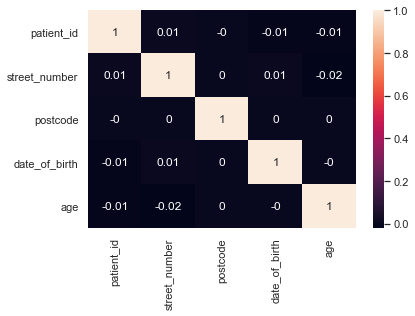

In [55]:
# Correlation between features
sns.heatmap(data=df_patient.corr().round(2), annot=True)

En affichant les codes postaux en fonction des numéros de rue, je m'aperçois clairement de 2 valeurs aberrantes apparentes qui sont supérieurs à 25000 dans la variable **street_number**. Et en utilisant Google Maps pour la localisation, ces adresses n'existent pas.

Je les remplace donc par une valeur NaN.

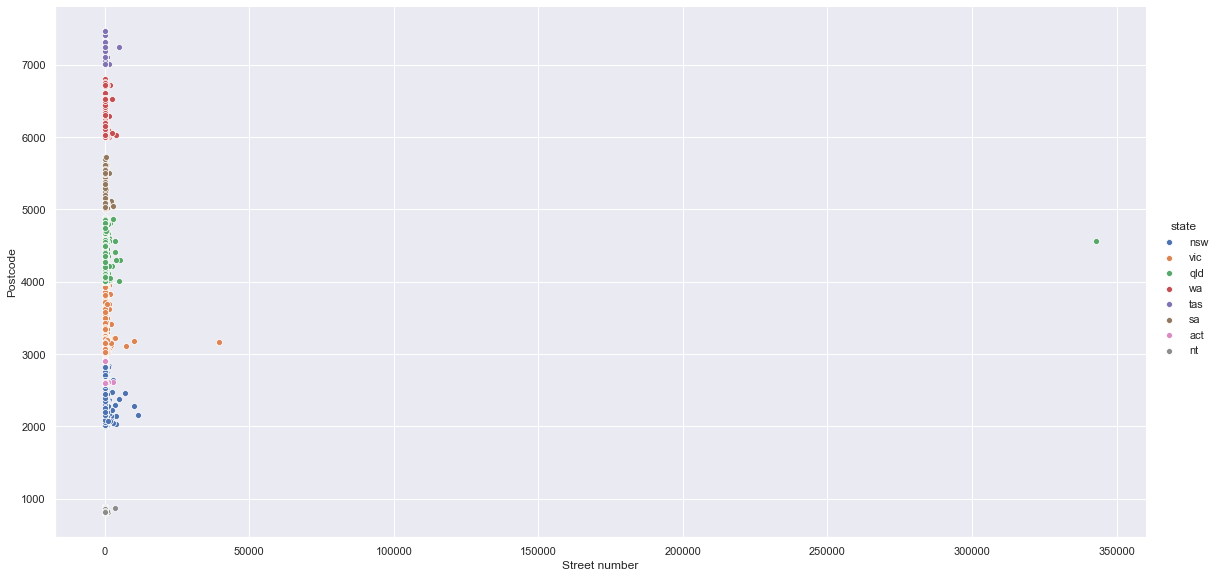

In [56]:
# Display post_code as a function of street_number and draw by state 
grid = sns.FacetGrid(data=df_patient, hue='state', height=8, aspect=2)
grid.map_dataframe(sns.scatterplot, x='street_number', y='postcode')
grid.set_xlabels(label='Street number')
grid.set_ylabels(label='Postcode')
grid.add_legend()

In [57]:
# View outliers in street_number
df_patient[df_patient.street_number > 25000]

,patient_id,name,street_number,address_1,suburb,state,postcode,date_of_birth,age,phone_number
7055,869217,nicholas fitzpatrick,342951.0,taylor place,normanhurst,qld,4560,19680530.0,13.0,08 37654995
12440,446997,jessica matthews,39430.0,airey crescent,plumpton,vic,3173,19331014.0,29.0,02 15333991


In [58]:
# Replace outliers in street_number by NaN value
df_patient.loc[df_patient.street_number > 25000, 'street_number'] = np.NaN

La variable **age** compte plusieurs valeurs manquantes (plus de **15%** des données) et plusieurs valeurs aberrantes avec la boîte à moustaches.

La variable **age** est asymétrique avec une médiane (**29**) assez proche de la moyenne (**27.53**).

In [59]:
# NaN values count
df_patient.age.isna().sum()

3959

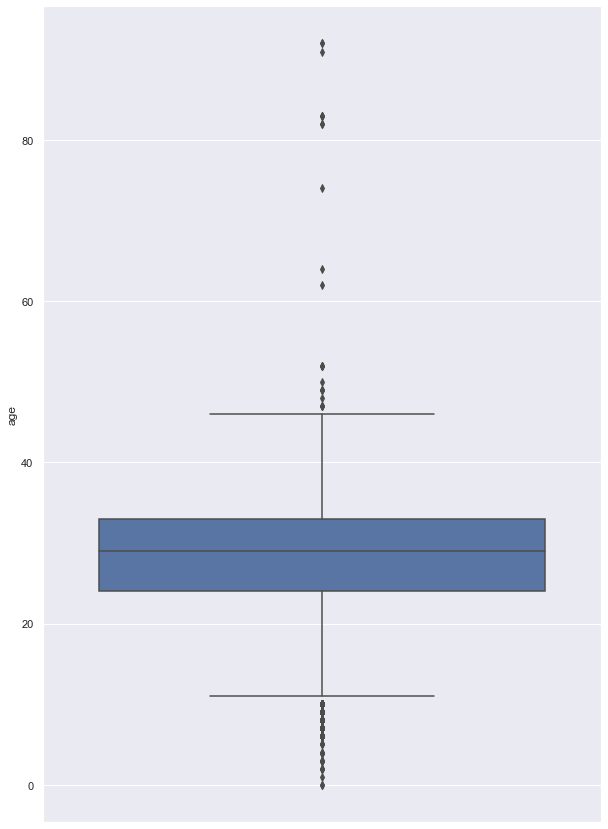

In [60]:
# Boxplot of feature age
fig, ax = plt.subplots(figsize=(10, 15))
sns.boxplot(y=df_patient.age, ax=ax)

In [61]:
# Description of feature age
df_patient.age.describe()

count    15842.000000
mean        27.532067
std          7.807732
min          0.000000
25%         24.000000
50%         29.000000
75%         33.000000
max         92.000000
Name: age, dtype: float64

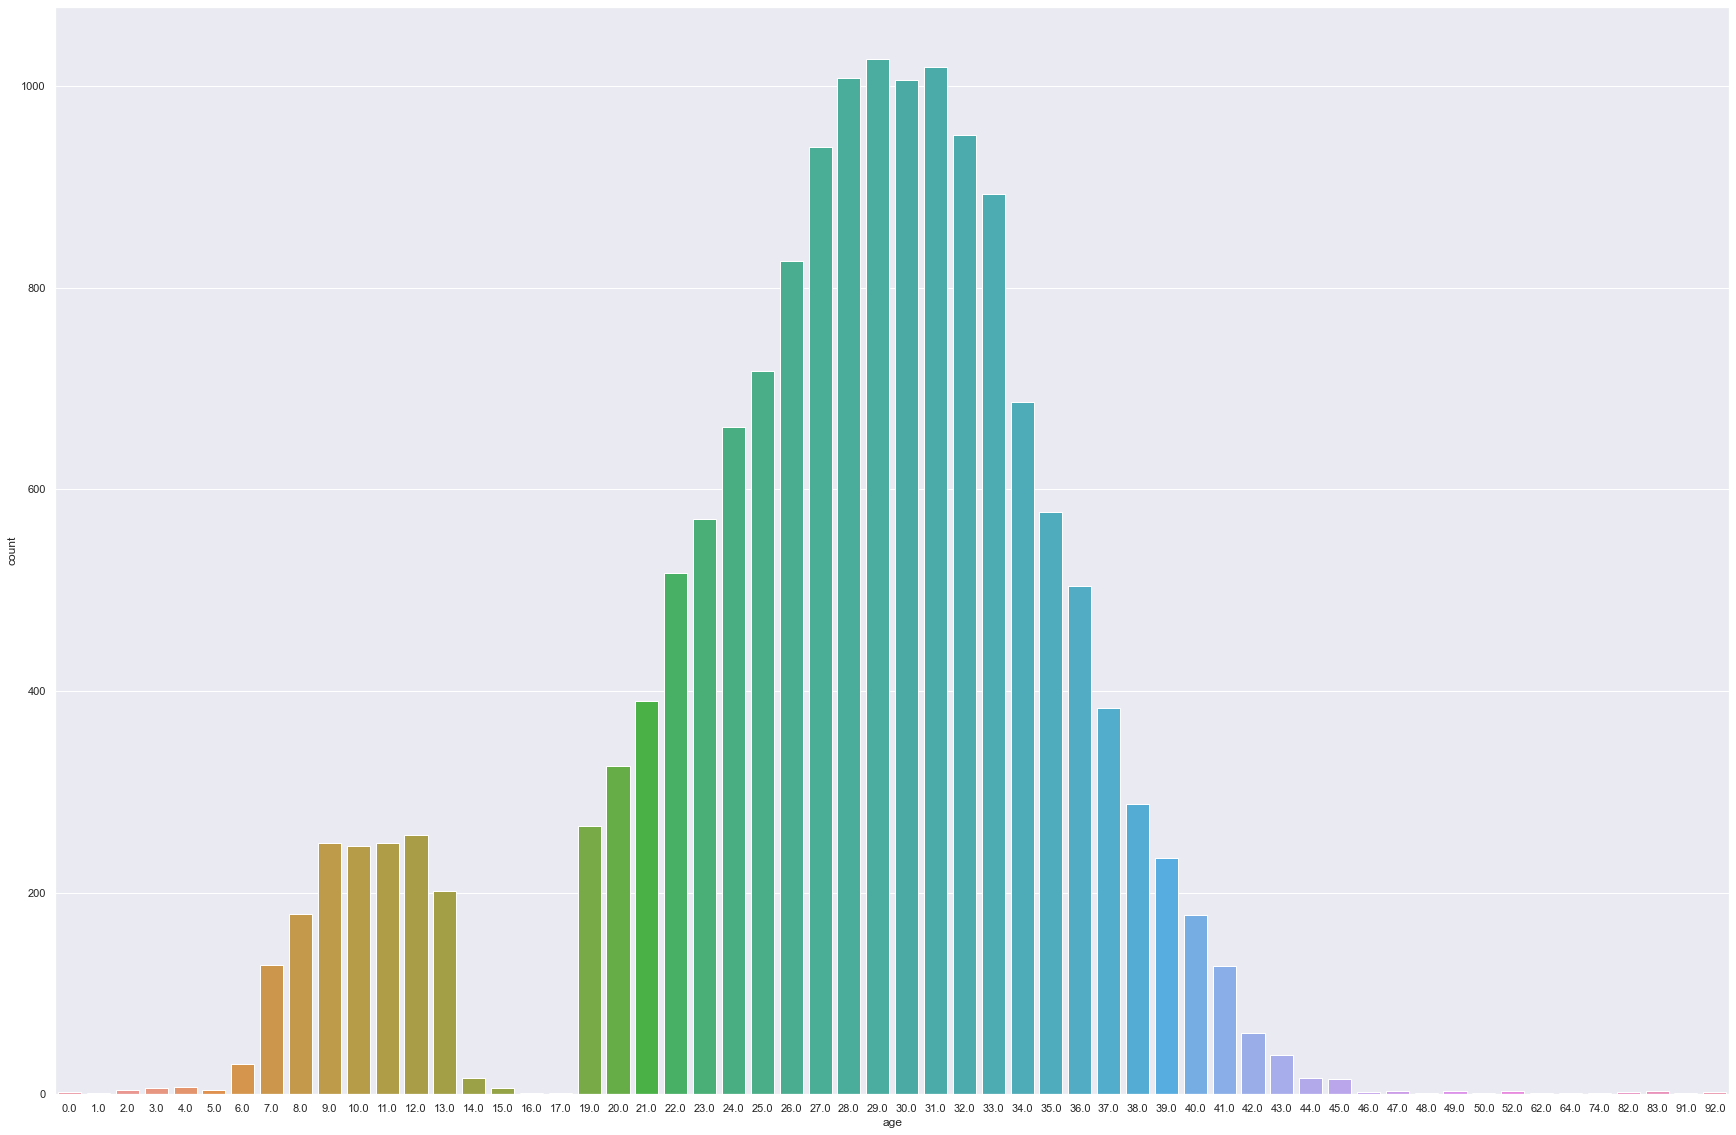

In [62]:
# Distribution of feature age
fig, ax = plt.subplots(figsize=(30, 20))
sns.countplot(x=df_patient.age, ax=ax)

Pour afficher les outliers de la variable **age**,je vais créer une nouvelle variable de type temporelle et choisir le mode de correction de la variable **age**.

In [63]:
# Fill NaN by the value 0
df_patient.date_of_birth = df_patient.date_of_birth.fillna(0)

In [64]:
# After filling
df_patient.date_of_birth.value_counts()

0.0           1982
19900526.0       6
19630130.0       6
19220519.0       6
19210620.0       6
              ... 
19410618.0       1
19920811.0       1
19850217.0       1
19640925.0       1
19551204.0       1
Name: date_of_birth, Length: 13542, dtype: int64

In [65]:
# Create a new feature of date type
df_patient['date_of_birth_date'] = df_patient.date_of_birth.apply(datetime.date.fromtimestamp)

Nous nous retrouvons avec seulement 14 valeurs uniques dans la variable **date_of_birth_date**.

In [66]:
# Description of new feature
df_patient.date_of_birth_date.describe()

count          19801
unique            14
top       1970-01-01
freq            1982
Name: date_of_birth_date, dtype: object

In [67]:
# Print values count of new feature
df_patient.date_of_birth_date.value_counts()

1970-01-01    1982
1970-08-17    1681
1970-08-13    1651
1970-08-11    1612
1970-08-16    1557
1970-08-14    1548
1970-08-19    1545
1970-08-09    1523
1970-08-10    1483
1970-08-18    1465
1970-08-15    1431
1970-08-12    1406
1970-08-20     740
1970-08-08     177
Name: date_of_birth_date, dtype: int64

En fonction de chaque date, plusieurs valeurs aberrantes semblent se dégager selon la figure ci-dessous.

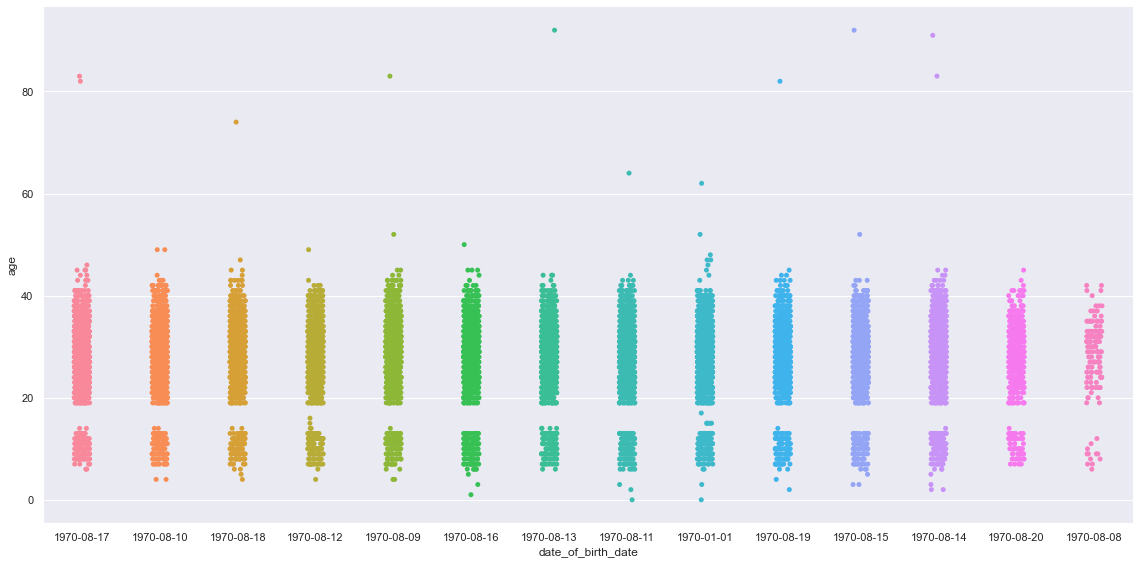

In [68]:
# Plot age by date_of_birth_date
sns.catplot(data=df_patient, x='date_of_birth_date', y='age', height=8, aspect=2)

In [69]:
# Age mean by date of birth
df_patient[['date_of_birth_date', 'age']].groupby('date_of_birth_date', as_index=False).\
                                                mean().sort_values('age', ascending=True)

,date_of_birth_date,age
5,1970-08-12,27.321809
4,1970-08-11,27.354380
9,1970-08-16,27.372922
8,1970-08-15,27.383290
7,1970-08-14,27.429498
13,1970-08-20,27.435200
10,1970-08-17,27.438700
12,1970-08-19,27.447737
6,1970-08-13,27.529915
3,1970-08-10,27.642978


*Traitement de la variable **street_number** :*
* corriger les valeurs manquantes (**1.91%**) par la moyenne des valeurs.

Les valeurs corrigées seront donc reconnaissables dans notre jeu de données.

In [70]:
# Description of feature street_number
df_patient.street_number.describe()

count    19420.000000
mean        78.960659
std        291.569161
min          0.000000
25%         10.000000
50%         24.000000
75%         60.000000
max      12569.000000
Name: street_number, dtype: float64

In [71]:
print("Before correction, number of NaN values in street_number = ", df_patient.street_number.isna().sum())

Before correction, number of NaN values in street_number =  381


In [72]:
df_patient.street_number = df_patient.street_number.fillna(df_patient.street_number.mean())
print("After correction, number of NaN values in street_number = ", df_patient.street_number.isna().sum())

After correction, number of NaN values in street_number =  0


*Traitement de la variable **date_of_birth** :*
* corriger les valeurs manquantes (**10.06%**) par la valeur 0 :
    * **tâche déjà réalisée plus haut**.

In [73]:
# After correction : NaN values count
df_patient.date_of_birth.isna().sum()

0

La faible corrélation et le manque de cohérence entre les variables **date_of_birth** et **age** rendent difficile le choix de la méthode de correction de la variable **age**. En effet, il y a des personnes nées le même jour mais ayant des âges différents. La connaissance du jour de récolte des données m'aurait permis de discerner sur ce problème.

Je vais donc ignorer les valeurs aberrantes et les considérer comme des valeurs justes pour faire le traitement des valeurs manquantes.

*Traitement de la variable **age** :*
* corriger les valeurs manquantes par la moyenne d'âge des personnes ayant le même jour de naissance.

In [74]:
# Before correction : NaN values count
df_patient.age.isna().sum()

3959

In [75]:
def fill_age(dataframe=df_patient):
    """
    This function fills NaN values of the feature age of dataframe df_patient.
        It returns nothing.
    
    @parameter:
        dataframe: a pandas DataFrame. By default, its value is df_patient.
    """
    
    # Create dataframe of age mean by date of birth (date type)
    df_mean_age = dataframe[['date_of_birth_date', 'age']].groupby('date_of_birth_date', as_index=False).\
                                                mean().sort_values('age', ascending=True)
    
    # Convert df_mean_age to dict
    dict_mean_age = df_mean_age.set_index('date_of_birth_date').T.to_dict('list')
    
    # Correct NaN values of feature age
    for key, value in dict_mean_age.items():
        dataframe.loc[(dataframe['date_of_birth_date'] == key) & (dataframe.age.isna() == True), 'age'] = value

In [76]:
# Correction
fill_age()

In [77]:
# After correction : NaN values count
df_patient.age.isna().sum()

0

Après le traitement des variables numériques, je note :
* qu'il n'y a plus aucune valeur manquante ;
* une baisse de la moyenne des variables **street_number_** et **date_of_birth** vu que les valeurs manquantes ont toutes été corrigées par 0 ;
* une amélioration de la symétrie de la variable **age** car la médiane est beaucoup plus proche de la moyenne (qui a augmentée légèrement) qu'elle ne l'était.

In [78]:
df_patient.describe()

,patient_id,street_number,postcode,date_of_birth,age
count,19801.000000,19801.000000,19801.000000,1.980100e+04,19801.000000
mean,553955.766830,78.960659,3667.782991,1.754547e+07,27.532267
std,260246.238454,288.750286,1402.307150,5.858154e+06,6.984206
min,100005.000000,0.000000,800.000000,0.000000e+00,0.000000
25%,329991.000000,10.000000,2485.000000,1.916110e+07,25.000000
50%,556356.000000,25.000000,3194.000000,1.944062e+07,27.669178
75%,779418.000000,64.000000,4601.000000,1.972083e+07,32.000000
max,999993.000000,12569.000000,7470.000000,1.999123e+07,92.000000


## Question 2
*Écrire une fonction de détection et de suppression des doublons*

Après l'analyse et le traitement des données, je fais l'hypothèse suivante pour la détection de doublons :
* Un patient n'est pas unique par son identifiant (**patient_id**) ; ce qui devait être le cas mais les données ont sûrement été récoltées à différentes époques.
    * *Une illustration (example 1) ci-dessous le montre bien.*
* Un patient est unique par son contact (**phone_number**), son adresse (**postcode**, **state**) et son âge (**age**). *Les autres variables présentent plusieurs erreurs de saisie.*
    * *Une illustration (example 2) ci-dessous le montre bien.*

Ce sont les variables de la ligne ci-dessus qui serviront à la détection de doublons.

In [79]:
def count_duplicates_by_column(dataframe=df_patient):
    """
    This function creates a dataframe which is the count of all duplicates by feature of df_patient.
        It returns a dataframe.
    
    @parameter:
        dataframe: a pandas DataFrame. By default, its value is df_patient.
    
    @return:
        df_duplicates_number: a pandas DataFrame with one column.
    """
    
    # Create a dataframe of number of column's duplicated values
        # Create a dictionnary that collected values
    duplicates_number = {}
    for column in dataframe.columns.values:
        duplicates_number[column] = len(dataframe[dataframe[column].duplicated() == True])
    
        # Create a dataframe from the dictionnary that created above
    df_duplicates_number = pd.DataFrame.from_dict(duplicates_number, orient='index', \
                                              columns=['duplicates_number']).\
                                                                sort_values('duplicates_number', ascending=True)
    
    return df_duplicates_number

In [80]:
# View duplicates by feature
count_duplicates_by_column()

,duplicates_number
patient_id,197
phone_number,2068
name,2734
date_of_birth,6259
address_1,15484
suburb,16901
postcode,17793
street_number,18971
age,19729
date_of_birth_date,19787


In [81]:
# Patient_id is not reliable for detecting duplicates
df_patient[df_patient.patient_id.duplicated() == True]['patient_id'].value_counts()

428821    2
605950    1
470608    1
887646    1
527709    1
         ..
227192    1
853158    1
853315    1
848423    1
166912    1
Name: patient_id, Length: 196, dtype: int64

In [82]:
# Example 1
df_patient[df_patient.patient_id == 428821]

,patient_id,name,street_number,address_1,suburb,state,postcode,date_of_birth,age,phone_number,date_of_birth_date
4094,428821,rory webb,24.0,houghton place,wendouree,vic,3216,19920516.0,31.00000,03 35306101,1970-08-19
5959,428821,chelsea tulla,23.0,britten-jones drive,ballarat,vic,3057,19270809.0,11.00000,04 87459349,1970-08-12
7609,428821,joshua meuris,25.0,monaro crescent,south melbourne,nsw,2285,19060502.0,27.76249,0,1970-08-09


In [83]:
# Phone_number is very reliable for detecting duplicates
df_patient[df_patient.phone_number.duplicated() == True]['phone_number'].value_counts()

0              910
04 33794273      3
08 38366451      3
04 61802611      3
07 26649590      3
              ... 
04 76722284      1
02 13744238      1
02 37735964      1
07 24551520      1
02 73266082      1
Name: phone_number, Length: 682, dtype: int64

In [84]:
# Example 2
df_patient[df_patient.phone_number == '02 03546747']

,patient_id,name,street_number,address_1,suburb,state,postcode,date_of_birth,age,phone_number,date_of_birth_date
1201,489678,jacob svenson,48.0,wagga street,kempsey,nsw,2009,19431221.0,31.0,02 03546747,1970-08-13
6086,669354,jacob svenson,48.0,wagga soreet,kempsey,nsw,2009,19431221.0,31.0,02 03546747,1970-08-13
7365,576055,jacob svenson,98.0,wagga street,kempsey,nsw,2009,0.0,31.0,02 03546747,1970-01-01
13795,909797,jaob svenson,48.0,wagga smreet,kempsey,nsw,2009,19431221.0,31.0,02 03546747,1970-08-13


In [85]:
def detect_duplicates(dataframe=df_patient.copy()):
    """
    This function allows the detection and the deletion of duplicates in df_patient.
        It returns a new version of df_patient without duplicates.
    
    In our case, a duplicate is a dataframe's row that is repeated more than once taking into 
        account data entry errors.
    
    @parameter:
        dataframe: a pandas DataFrame. By default, its value is df_patient.
    @return:
        dataframe: a pandas DataFrame without duplicates.
    """
    
    # Collect in df_duplicates all lines duplicated of dataframe
    df_duplicates = dataframe[(dataframe.phone_number.duplicated() == True) & \
                              (dataframe.postcode.duplicated() == True) & \
                              (dataframe.state.duplicated() == True) & \
                              (dataframe.age.duplicated() == True)]
    
    # Collect df_duplicates's indexes
    indexes = df_duplicates.index
    
    # Delete all lines duplicated values of dataframe
    dataframe = dataframe.drop(index=indexes)
    
    return dataframe[:]

## Question 3
*Écrire une ou plusieurs fonctions (eg utilisant [Pytest](https://docs.pytest.org/en/stable/)) afin de tester la qualité de votre fonction.*

In [86]:
import pytest

def test_detect_duplicated():
    assert type(detect_duplicates()) == pd.DataFrame, "You must return a dataframe."
    assert detect_duplicates().shape == (17862, 11), "The shape is incorrect."
    assert len(detect_duplicates()) < len(df_patient), "You must delete duplicates of your new dataframe."

In [87]:
test_detect_duplicated()

## Question 4
*Étudier la prévalence de la maladie dans la population en faisant une analyse exploratoire des données.*

In [88]:
# Apply detect_duplicates and put its output in df_patient
df_patient = detect_duplicates()

In [90]:
# Describe df_patient
df_patient.describe(include='all')

,patient_id,name,street_number,address_1,suburb,state,postcode,date_of_birth,age,phone_number,date_of_birth_date
count,17862.000000,17862,17862.000000,17862,17862,17862,17862.000000,1.786200e+04,17862.000000,17862,17862
unique,NaN,15919,NaN,4074,2700,8,NaN,NaN,NaN,17733,14
top,NaN,clarke,NaN,,toowoomba,nsw,NaN,NaN,NaN,0,1970-01-01
freq,NaN,13,NaN,698,345,6022,NaN,NaN,NaN,88,1772
mean,554464.620703,NaN,76.237100,NaN,NaN,NaN,3668.319225,1.756269e+07,27.553706,NaN,NaN
std,260181.138816,NaN,272.326651,NaN,NaN,NaN,1403.738428,5.834944e+06,6.921853,NaN,NaN
min,100005.000000,NaN,0.000000,NaN,NaN,NaN,800.000000,0.000000e+00,0.000000,NaN,NaN
25%,331319.000000,NaN,10.000000,NaN,NaN,NaN,2484.000000,1.916102e+07,25.000000,NaN,NaN
50%,556198.000000,NaN,25.000000,NaN,NaN,NaN,3194.000000,1.944072e+07,27.669178,NaN,NaN
75%,779832.000000,NaN,64.000000,NaN,NaN,NaN,4610.000000,1.972079e+07,32.000000,NaN,NaN


### Description des données : df_pcr

*Quelles sont les variables disponibles ?*

In [91]:
print(df_pcr.columns.values)

['patient_id' 'pcr']


*Lesquelles des variables sont catégorielles ou quantitatives ?*
* Nominale : pcr

In [92]:
# Preview data
df_pcr.head()

,patient_id,pcr
0,653091,N
1,347667,Negative
2,708481,Positive
3,148825,Negative
4,150081,Negative


In [93]:
df_pcr.tail()

,patient_id,pcr
8795,249457,N
8796,279689,Positive
8797,975612,N
8798,884429,Positive
8799,272409,Negative


*Lesquelles des lignes sont en double dans les données ?*

Il y a 14 doublons apparents qui seront supprimés immédiatement.

In [94]:
df_pcr[df_pcr.duplicated() == True]

,patient_id,pcr
2251,728889,Negative
2934,159500,N
4666,651216,N
4741,328071,Positive
4859,527530,Negative
4939,411955,N
5071,655839,Negative
5724,670706,Positive
5745,512755,Negative
6176,483152,Negative


In [95]:
# Delete duplicates
df_pcr = df_pcr.drop_duplicates()

*Lesquelles des variables comporteraient des erreurs ou des valeurs manquantes ?*

Il n'y aucune valeur manquante.

In [96]:
df_pcr.isna().sum()

patient_id    0
pcr           0
dtype: int64

*Quels sont les types des différentes variables ?*
* 1 variable entière (int)
* 1 variable de chaînes de caractère (string)

In [97]:
df_pcr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8786 entries, 0 to 8799
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  8786 non-null   int64 
 1   pcr         8786 non-null   object
dtypes: int64(1), object(1)
memory usage: 205.9+ KB


#### Analyse de la variable pcr

La variable **pcr** compte 4 valeurs uniques qu'on peut réduire à 2 :
* *Négative* deviendra *N* ;
* *Positive* en *P*.

In [98]:
# Description
df_pcr.pcr.describe()

count     8786
unique       4
top          N
freq      3475
Name: pcr, dtype: object

In [99]:
# Count each unique values
df_pcr.pcr.value_counts()

N           3475
Negative    3129
Positive    1281
P            901
Name: pcr, dtype: int64

In [100]:
# Correction
df_pcr.pcr = df_pcr.pcr.replace("Negative", 'N')
df_pcr.pcr = df_pcr.pcr.replace("Positive", 'P')

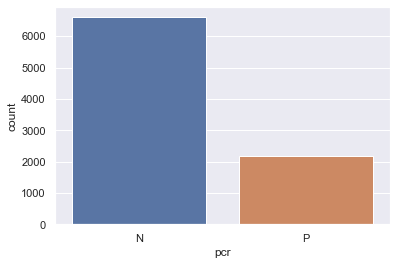

In [102]:
# After correction
sns.countplot(df_pcr.pcr)